In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

## First load a few images to identify ROIs and check threshold

In [5]:
pgroup='p19262'
fc = FileChooser(f'/sf/alvra/data/{pgroup}/raw/scan_data')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19262/raw/scan_data', filename='', title='HTML(value='', layout=Layout(displ…

In [6]:
nshots = 100
threshold_low = 2
threshold_high = 10

######################################################################

total_image, total_image_thr, total_for_hist, total_for_hist_thr = \
XES_static_full(fc.selected, pgroup, threshold_low, threshold_high, nshots)

/sf/alvra/data/p19262/scan_data/265_XAS_CpRhCO2dec_250fs/run_013353.JF02T09V02.h5
Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p19262/raw/JF_pedestals/run_014322.JF02T09V02.res.h5
jungfrau file: 03:08 05.12.2021
pedestal file: 08:58 05.12.2021
    mtime difference: -5:49:47.124645
Loaded 100 images
It took 4.42 seconds to process this file


<IPython.core.display.Javascript object>


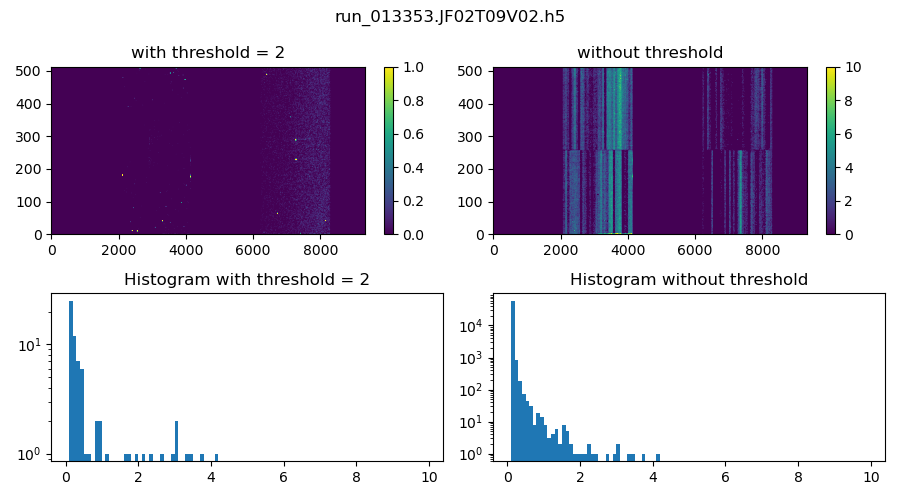

In [7]:
plt.figure(figsize=(9,5))
plt.suptitle(fc.selected_filename)
plt.subplots_adjust(wspace=0.5)

plt.subplot(221)
plt.imshow(total_image_thr, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("with threshold = {}".format(threshold_low))
plt.colorbar()

plt.subplot(223)
plt.title("Histogram with threshold = {}".format(threshold_low))
plt.hist(total_for_hist_thr.ravel(), bins=np.arange(0.1,10,0.1))
plt.yscale('log')

plt.subplot(222)
plt.imshow(total_image, origin="lower", aspect='auto', vmin=0, vmax=10)
plt.title("without threshold")
plt.colorbar()

plt.subplot(224)
plt.title("Histogram without threshold")
plt.hist(total_for_hist.ravel(), bins=np.arange(0.1,10,0.1))
plt.yscale('log')

plt.tight_layout()
plt.show()

## Next cells for RIXS scans, ONLY JF file!

In [2]:
pgroup = 'p19262'
fc = FileChooser(f'/sf/alvra/data/{pgroup}/raw/scan_info')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19262/raw/scan_info', filename='', title='HTML(value='', layout=Layout(displ…

In [3]:
roi1 = (2900, 3100, 180, 240) #signal CRY2 low
roi2 = (2900, 3100, 260, 320) #signal CRY2 up

roi3 = (7200, 7400, 200, 240) #signal CRY1 low
roi4 = (7200, 7400, 270, 310) #signal CRY1 up

threshold_low = 2
threshold_high = 10
nshots = None
#####################################################################################

RIXS_roi1, RIXS_roi2, RIXS_roi3, RIXS_roi4, Energy_eV,pids = \
RIXS_static_4ROIs(fc.selected, pgroup, roi1, roi2, roi3, roi4, threshold_low, threshold_high, nshots)


It took 4.2 seconds to process this file

Job done! It took 218.8 seconds to process 51 file(s)


<IPython.core.display.Javascript object>


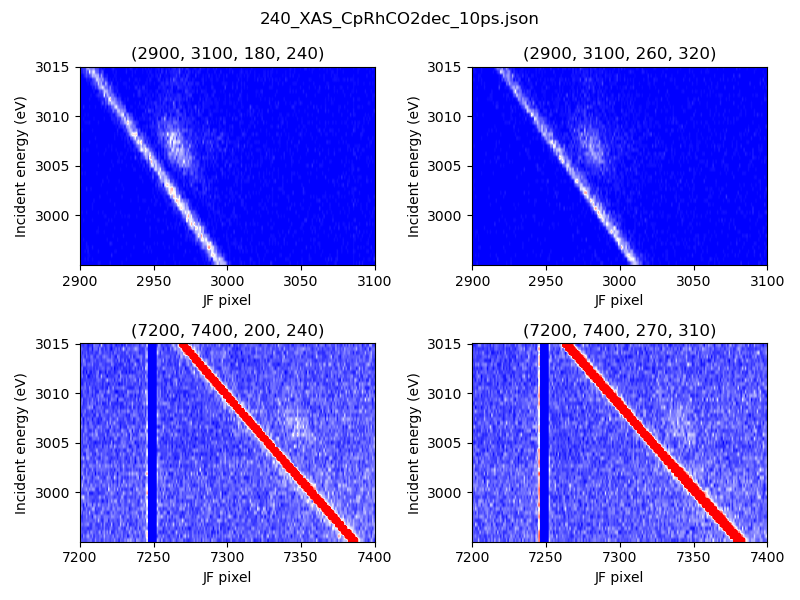

In [4]:
fig = plt.figure(figsize=(8, 6))
plt.suptitle(fc.selected_filename)

RIXSarray = [RIXS_roi1, RIXS_roi2, RIXS_roi3, RIXS_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    RIXS_roi = RIXSarray[i]
    roi = roiarray[i]

    location = 221+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.imshow(RIXS_roi,aspect = 'auto', cmap='bwr',origin='lower',\
             extent=[roi[0], roi[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=100)
    ax.set_xlabel('JF pixel')
    ax.set_ylabel('Incident energy (eV)')
    
    ax.set_title(str(roiarray[i]))
    
plt.tight_layout()

## Now with Energy calibration 

In [5]:
m_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_m_all.txt')
b_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_b_all.txt')

<IPython.core.display.Javascript object>


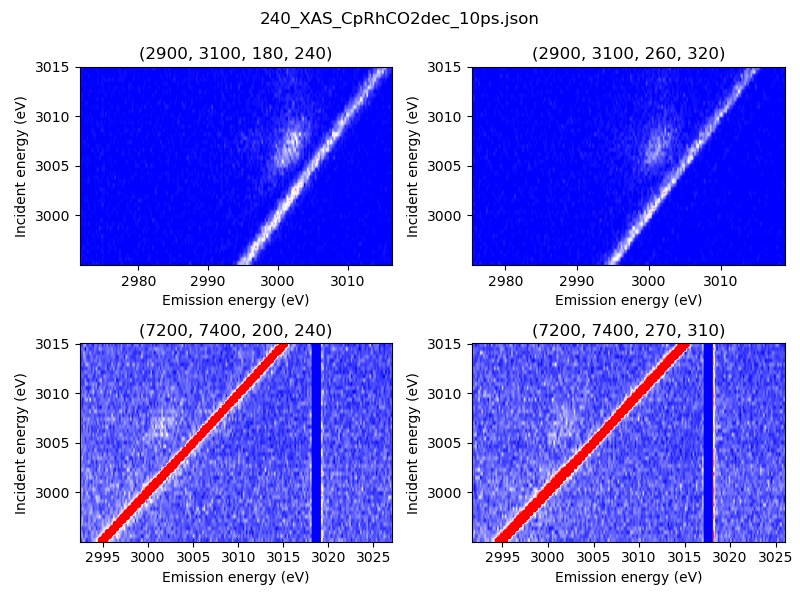

In [6]:
fig = plt.figure(figsize=(8, 6))
plt.suptitle(fc.selected_filename)

RIXSarray = [RIXS_roi1, RIXS_roi2, RIXS_roi3, RIXS_roi4]
roiarray = [roi1, roi2, roi3, roi4]
xaxisarray = []

for i in range(4):
    RIXS_roi = RIXSarray[i]
    roi = roiarray[i]
    
    xaxis = np.linspace(roi[0]*m_all[i]+b_all[i], roi[1]*m_all[i]+b_all[i], roi[1]-roi[0])
    xaxisarray.append(xaxis)

    location = 221+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.imshow(RIXS_roi,aspect = 'auto', cmap='bwr',origin='lower',\
             extent=[xaxis[0], xaxis[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=100)
    ax.invert_xaxis()
    ax.set_xlabel('Emission energy (eV)')
    ax.set_ylabel('Incident energy (eV)')
    
    ax.set_title(str(roiarray[i]))
xaxisarray = np.asarray(xaxisarray)
plt.tight_layout()

## Plot as a function of Energy loss

<IPython.core.display.Javascript object>


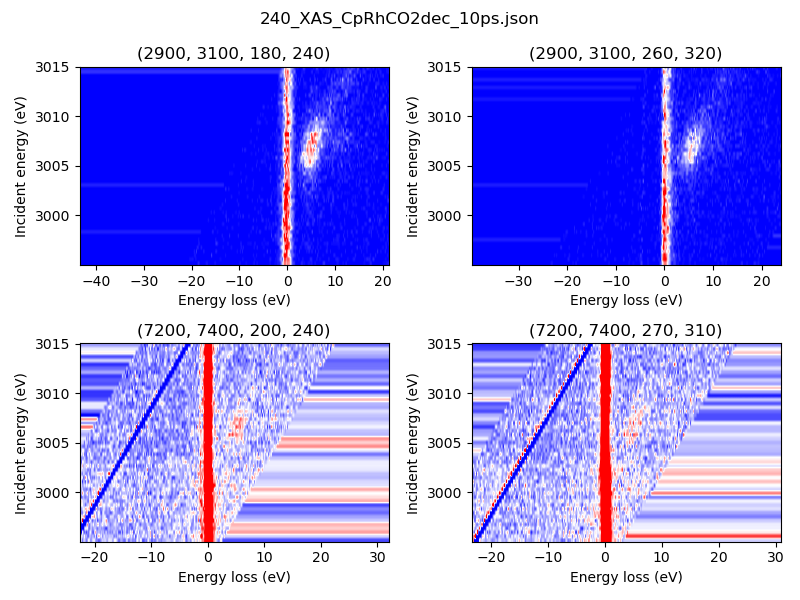

(51, 288)
(51, 291)
(51, 314)
(51, 315)


In [10]:
fig = plt.figure(figsize=(8, 6))
plt.suptitle(fc.selected_filename)

RIXSarray = [RIXS_roi1, RIXS_roi2, RIXS_roi3, RIXS_roi4]
RIXS_interp_array = []
interp_axis_array = []

for i in range(4):
    interp_axis, RIXS_map_interp = energy_loss(RIXSarray[i], xaxisarray[i], Energy_eV)
    RIXS_interp_array.append(RIXS_map_interp)
    interp_axis_array.append(interp_axis)
    
    location = 221+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.imshow(RIXS_map_interp,aspect = 'auto', cmap='bwr',origin='lower',\
             extent=[interp_axis[0], interp_axis[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=50)
    ax.set_xlabel('Energy loss (eV)')
    ax.set_ylabel('Incident energy (eV)')
    
    ax.set_title(str(roiarray[i]))
plt.tight_layout()
    
RIXS_interp_array = np.asarray(RIXS_interp_array)
interp_axis_array = np.asarray(interp_axis_array)